<a href="https://colab.research.google.com/github/nsp8/Machine-Learning-Resources/blob/colab-ml-practice/regression_flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Imports

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from google.colab import drive


#### Horizontal Chart for values associated with text labels

In [48]:
class Charts:
    def __init__(self, data, width=18, height=9, font_family="Sans Serif"):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.data = data
        self.y_pos = [i * 0.9 for i in range(len(data))]
        self.ax.barh(
            self.y_pos,
            self.data.values(),
            height=0.55,
            align="edge",
            color="blue",
        )
        self.font_family = font_family

    @property
    def max_data_value(self):
        return max(self.data.values())

    @property
    def min_data_value(self):
        return min(self.data.values())

    @property
    def axis_period(self):
        return int(self.max_data_value) // 10 or 1

    def set_axes(self):
        from math import ceil
        data_size = len(self.data)
        num_ticks = ceil(self.max_data_value)
        self.ax.xaxis.set_ticks([i * self.axis_period for i in range(num_ticks)])
        self.ax.xaxis.set_ticklabels(
            [i * self.axis_period for i in range(0, num_ticks)],
            size=16,
            fontfamily=self.font_family,
            fontweight=100,
        )
        self.ax.xaxis.set_tick_params(labelbottom=False, labeltop=True, length=0)
        self.ax.set_axisbelow(True)
        self.ax.grid(axis="x", color="#8C92AC", lw=1.2)
        self.ax.spines["left"].set_visible(False)
        self.ax.spines["right"].set_visible(False)
        self.ax.spines["top"].set_visible(False)
        self.ax.spines["bottom"].set_visible(False)
        self.ax.spines["left"].set_lw(1.5)
        self.ax.spines["left"].set_capstyle("butt")
        self.ax.yaxis.set_visible(False)
        return self

    def add_bar_text(self, label_object: dict):
        self.ax.text(
            x=label_object["x_pos"],
            y=label_object["y_pos"],
            s=label_object["text"],
            c=label_object["color"],
            fontfamily=self.font_family,
            fontsize=12,
            va="center",
            path_effects=label_object["path_effects"],
        )

    def add_labels(self, padding: float = 0.3):
        offset = 0.04
        for label, value, y_pos in zip(
            self.data.keys(), self.data.values(), self.y_pos
        ):
            metric_label = dict(
                x_pos=int(self.min_data_value) + (padding * 2.2),
                y_pos=(y_pos + 0.25),
                text=label,
                color="white",
                path_effects=[withStroke(linewidth=6, foreground="green")]
            )
            value_label = dict(
                x_pos=value,
                y_pos=(y_pos + 0.25),
                text=f"{round(value, 3)}0",
                color="green",
                path_effects=[withStroke(linewidth=6, foreground="white")]
            )
            if value < 0:
                metric_label["x_pos"] = self.min_data_value - (padding * 0.7) - offset
                metric_label["path_effects"] = [withStroke(linewidth=6, foreground="red")]
                metric_label["color"] = "white"
                value_label["color"] = "red"
                value_label["x_pos"] -= offset
            self.add_bar_text(metric_label)
            self.add_bar_text(value_label)

        return self

    def add_title(self, title, pos=0.5):
        self.fig.text(
            pos, 0.925, title, fontsize=16, fontweight="bold", fontfamily=self.font_family
        )
        return self

    def plot(self, title=None):
        self.set_axes().add_labels()
        if title:
            self.add_title(title)
        plt.show()


In [28]:
drive.mount('/gdrive/')

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


### **Data Loading**

In [29]:
base_folder_path = os.path.join('/gdrive', 'My Drive', 'Projects', 'ML Practice', 'Regression: flood prediction', 'data')
if os.path.exists(base_folder_path):
    print("Loading data ...")
    train_data = pd.read_csv(os.path.join(base_folder_path, "train.csv"))
    test_data = pd.read_csv(os.path.join(base_folder_path, "test.csv"))
    print("Loaded train and test files from Drive")
else:
    raise FileNotFoundError("Could not locate files")

Loading data ...
Loaded train and test files from Drive


## **Data Exploration**

### Basic statistical analyses

In [30]:
train_data.describe()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,...,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06,1.117957e+06
mean,5.589780e+05,4.921450e+00,4.926671e+00,4.955322e+00,4.942240e+00,4.942517e+00,4.934093e+00,4.955878e+00,4.927791e+00,4.942619e+00,...,4.946893e+00,4.953999e+00,4.931376e+00,4.929032e+00,4.925907e+00,4.927520e+00,4.950859e+00,4.940587e+00,4.939004e+00,5.044803e-01
std,3.227265e+05,2.056387e+00,2.093879e+00,2.072186e+00,2.051689e+00,2.083391e+00,2.057742e+00,2.083063e+00,2.065992e+00,2.068545e+00,...,2.072333e+00,2.088899e+00,2.078287e+00,2.082395e+00,2.064813e+00,2.074176e+00,2.068696e+00,2.081123e+00,2.090350e+00,5.102610e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.850000e-01
25%,2.794890e+05,3.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,...,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.000000e+00,3.000000e+00,4.700000e-01
50%,5.589780e+05,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.050000e-01
75%,8.384670e+05,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.400000e-01
max,1.117956e+06,1.600000e+01,1.800000e+01,1.600000e+01,1.700000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.600000e+01,...,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.700000e+01,1.800000e+01,1.900000e+01,1.600000e+01,1.600000e+01,7.250000e-01


In [31]:
# Null counts
train_data.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

In [32]:
# Data type information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

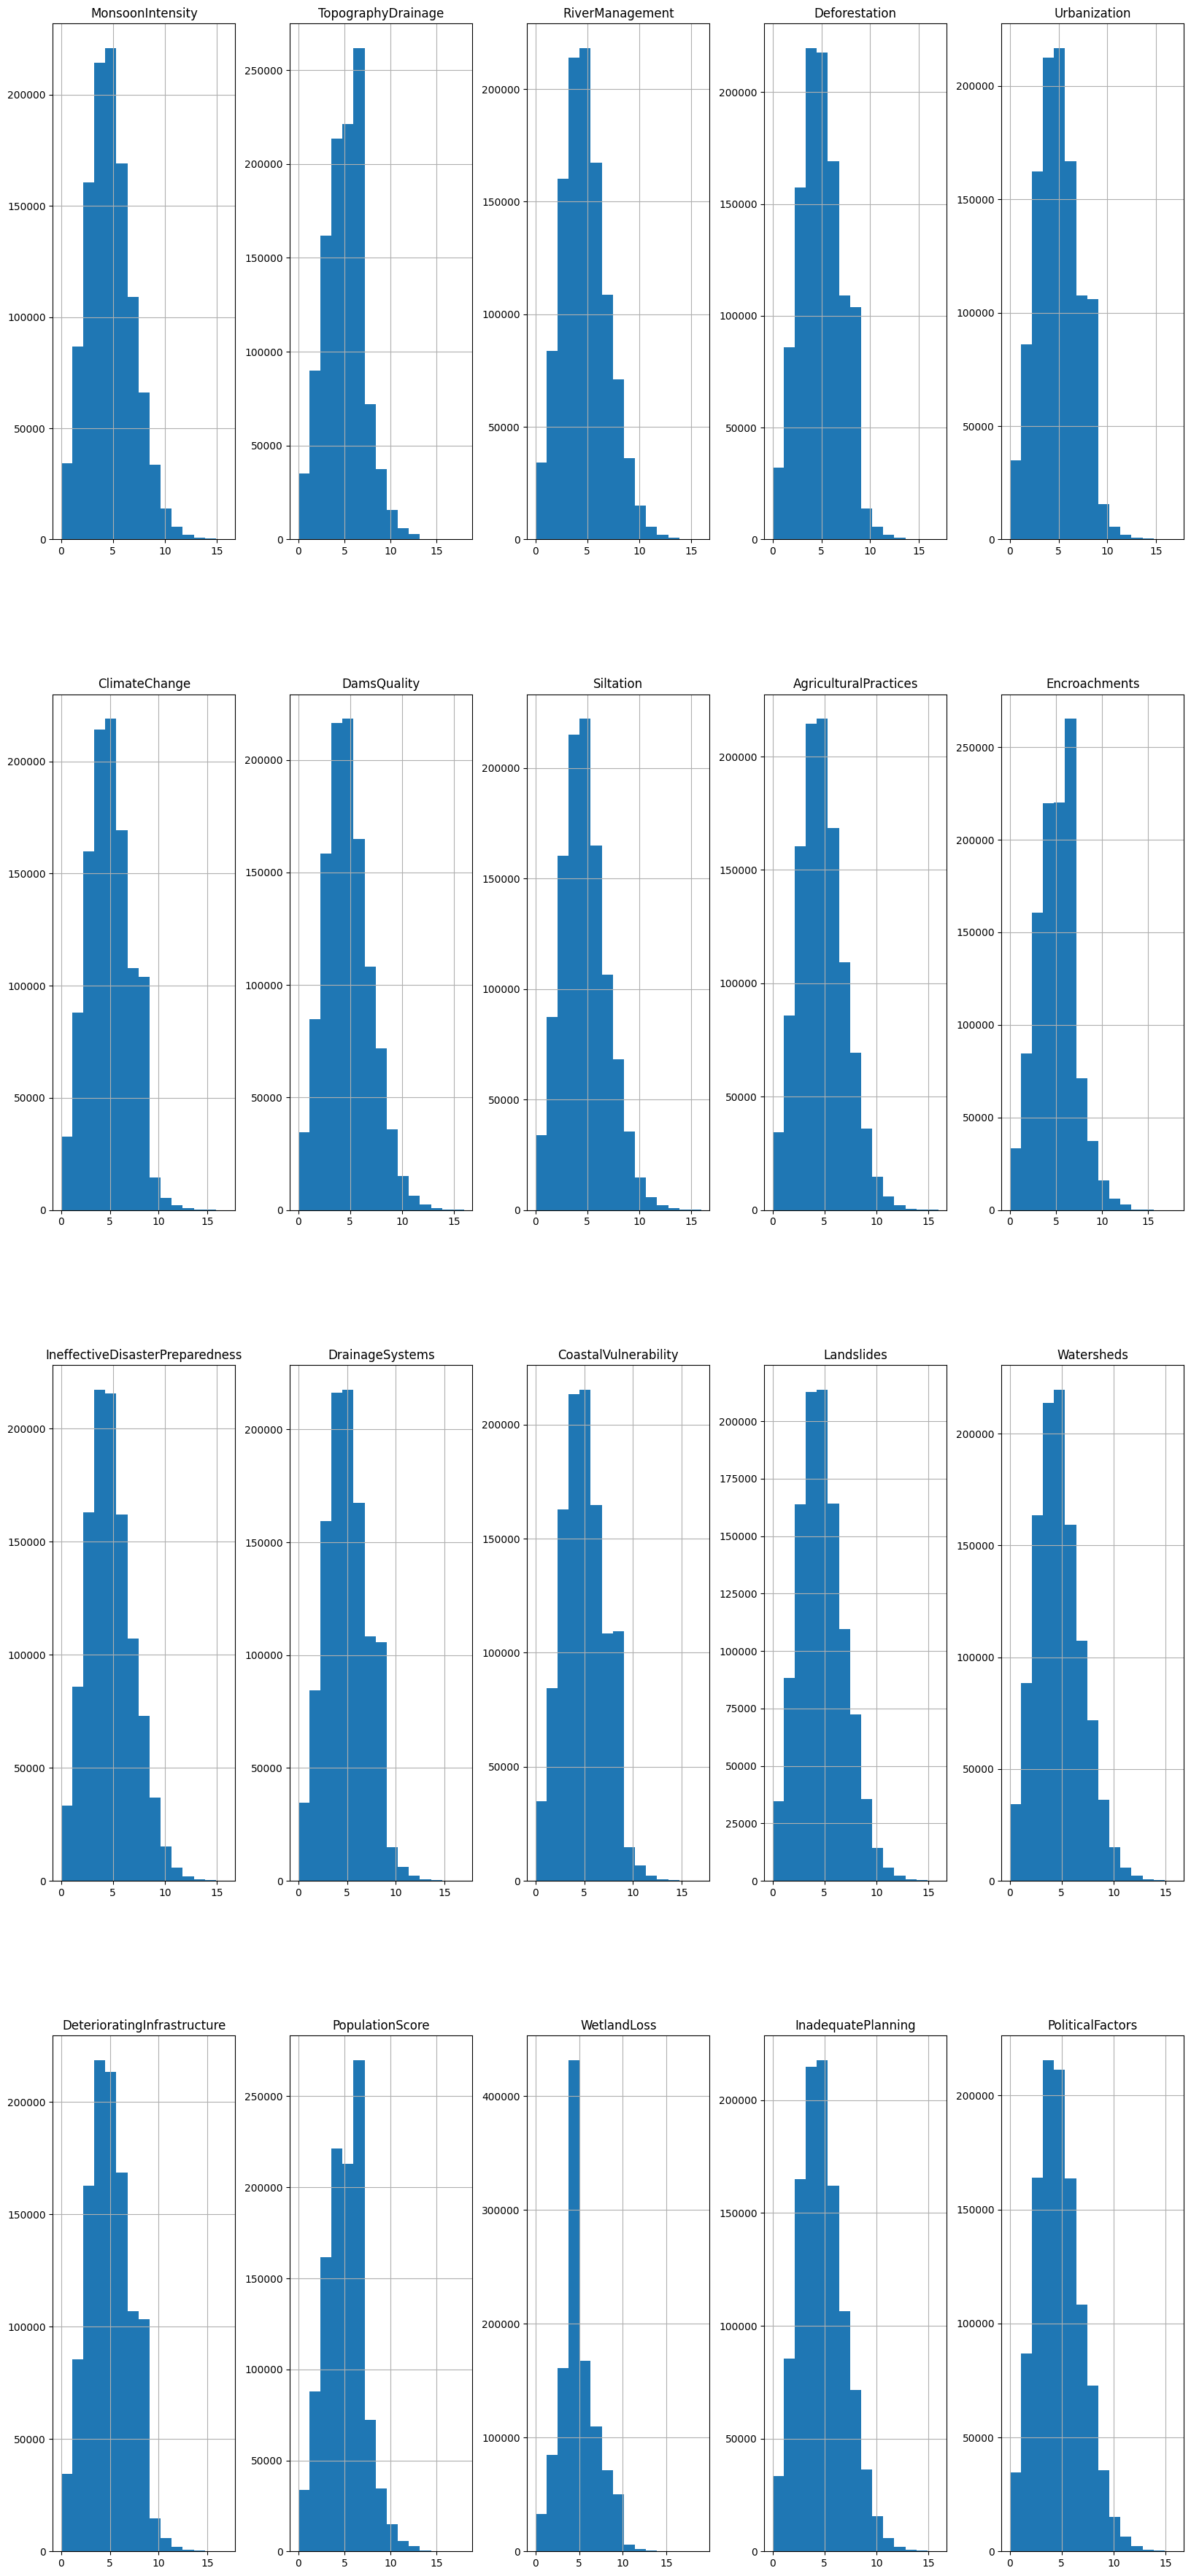

In [33]:
# Layout of data
features_train = train_data.set_index("id")
target_column = "FloodProbability"
label_train = features_train.pop(target_column)
features_train.hist(bins=15, figsize=(20, 45), layout=(4, 5))

array([[<Axes: title={'center': 'MonsoonIntensity'}>,
        <Axes: title={'center': 'TopographyDrainage'}>,
        <Axes: title={'center': 'RiverManagement'}>,
        <Axes: title={'center': 'Deforestation'}>,
        <Axes: title={'center': 'Urbanization'}>],
       [<Axes: title={'center': 'ClimateChange'}>,
        <Axes: title={'center': 'DamsQuality'}>,
        <Axes: title={'center': 'Siltation'}>,
        <Axes: title={'center': 'AgriculturalPractices'}>,
        <Axes: title={'center': 'Encroachments'}>],
       [<Axes: title={'center': 'IneffectiveDisasterPreparedness'}>,
        <Axes: title={'center': 'DrainageSystems'}>,
        <Axes: title={'center': 'CoastalVulnerability'}>,
        <Axes: title={'center': 'Landslides'}>,
        <Axes: title={'center': 'Watersheds'}>],
       [<Axes: title={'center': 'DeterioratingInfrastructure'}>,
        <Axes: title={'center': 'PopulationScore'}>,
        <Axes: title={'center': 'WetlandLoss'}>,
        <Axes: title={'center': '

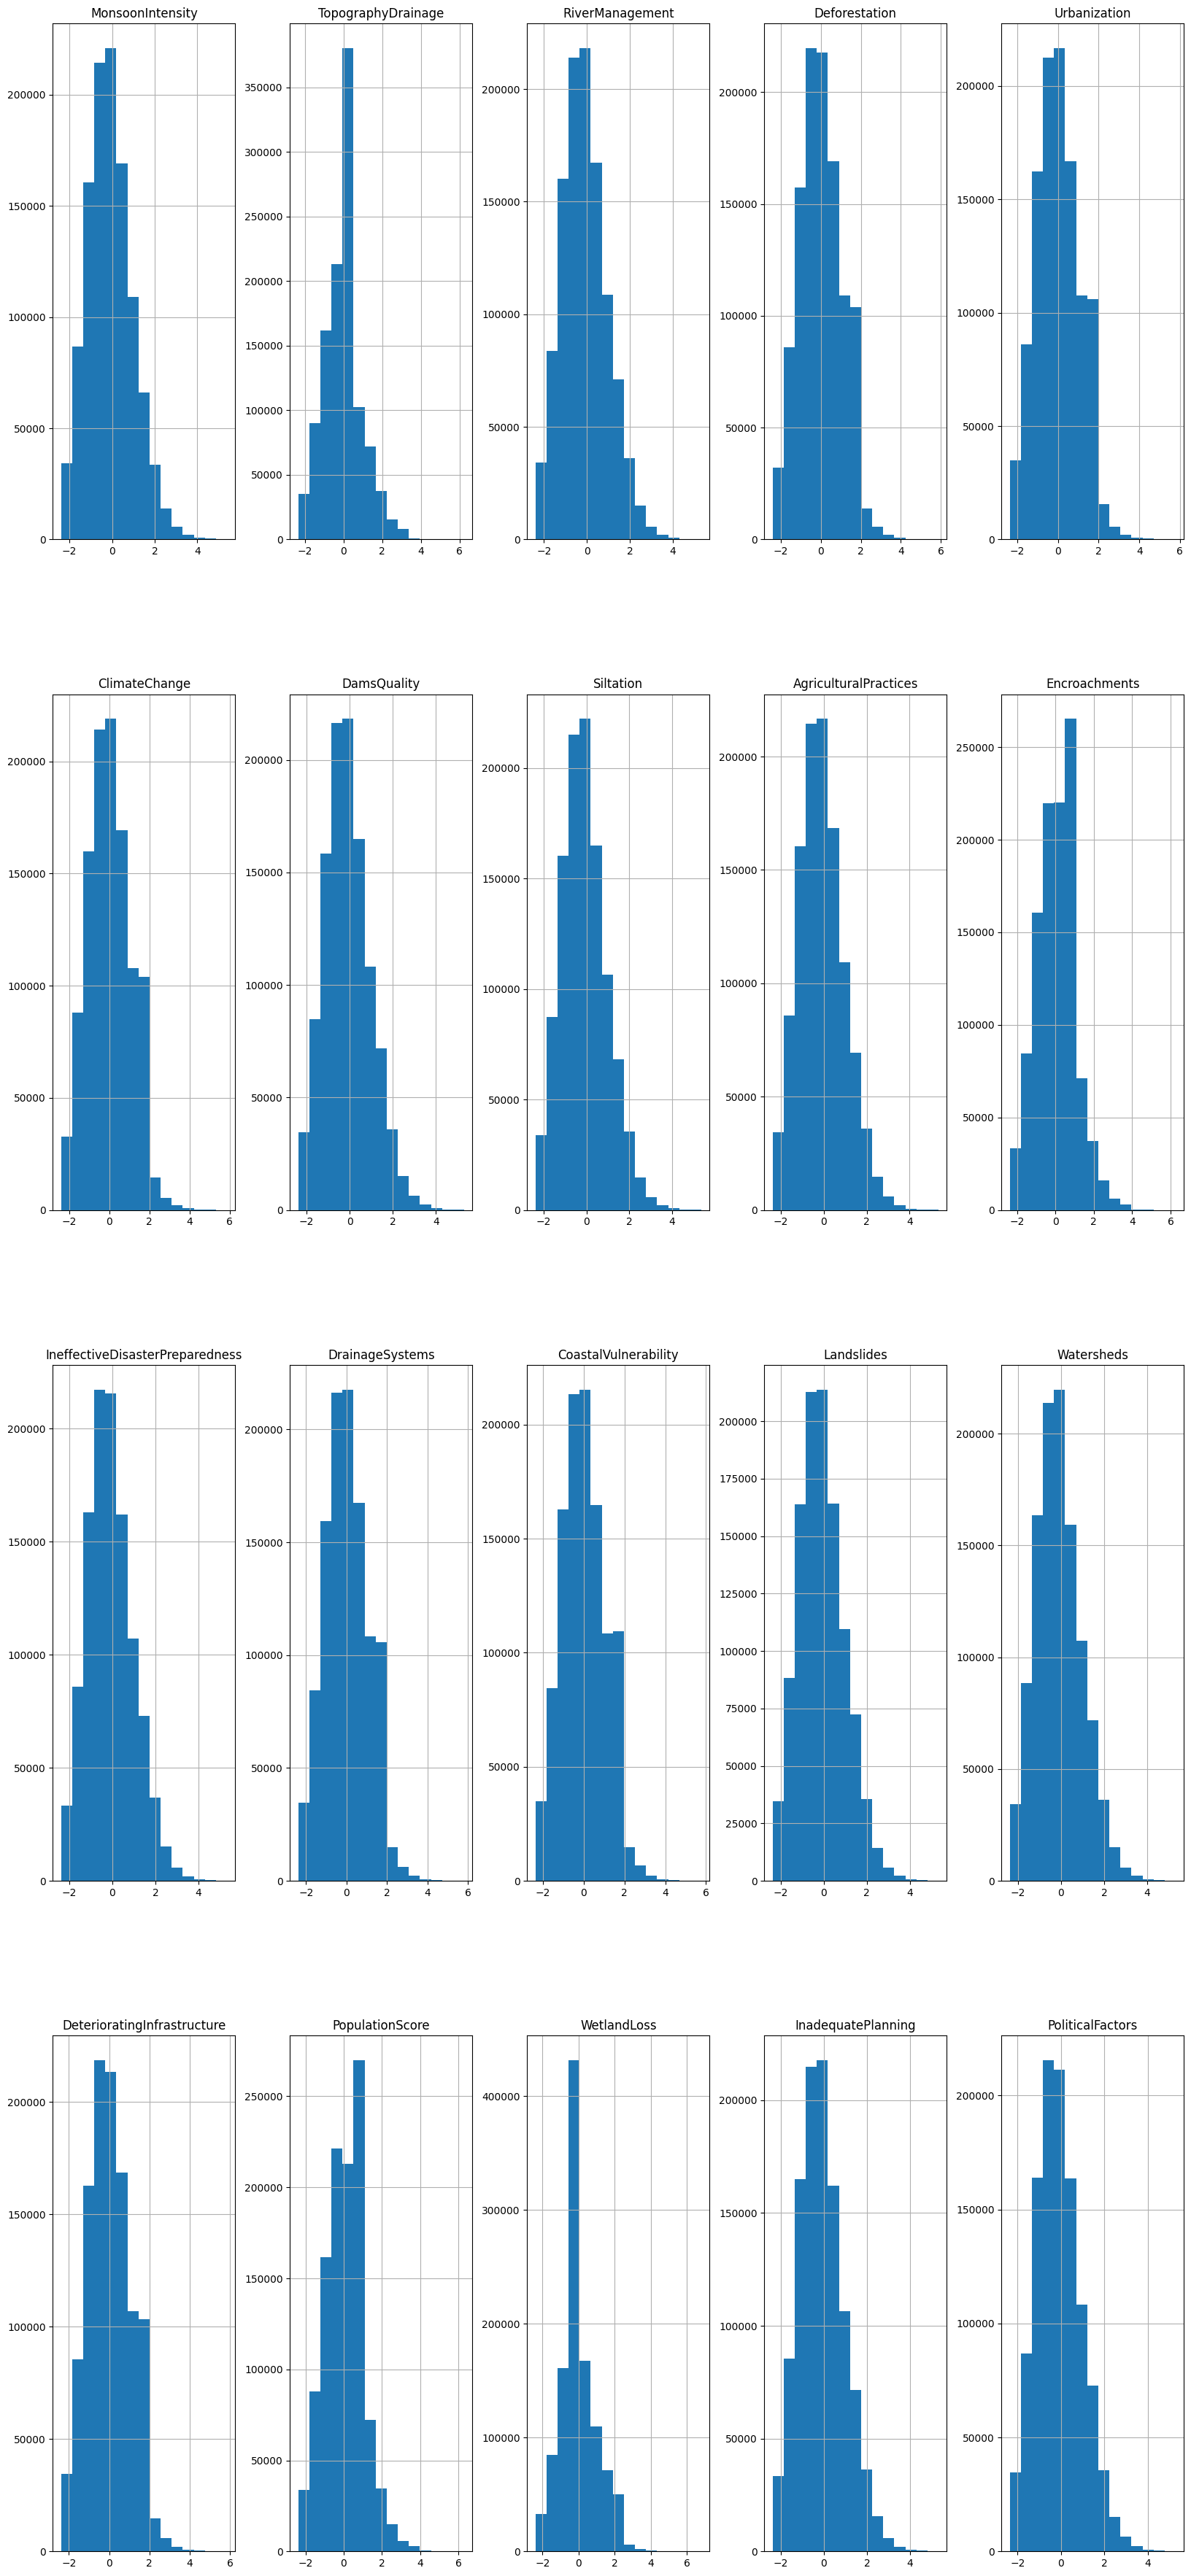

In [34]:
# Standardizing data

def standardize(data):
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    return standard_scaler.transform(data)
    # _data = data.copy(deep=True)
    # return (_data - _data.mean(axis=0)) / _data.std(axis=0)


features_train_standardized = pd.DataFrame(standardize(features_train), columns=features_train.columns)
features_train_standardized.hist(bins=15, figsize=(20, 45), layout=(4, 5))
# print(features_train_standardized.shape)

array([[<Axes: title={'center': 'FloodProbability'}>]], dtype=object)

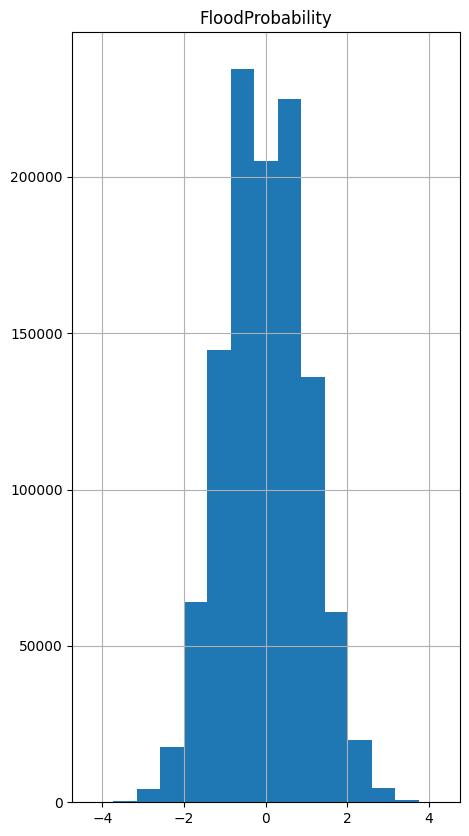

In [35]:
def standardize_labels(label_data):
    mean, std = label_data.mean(), label_data.std()
    return label_data.apply(lambda v: (v - mean) / std)


label_train_standardized = pd.DataFrame(standardize_labels(label_train), columns=[target_column])
label_train_standardized.hist(bins=15, figsize=(5, 10))

#### Train test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(features_train_standardized, label_train_standardized, test_size=0.25)

In [37]:
X_train.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

#### Correlation matrix of training features

<Axes: >

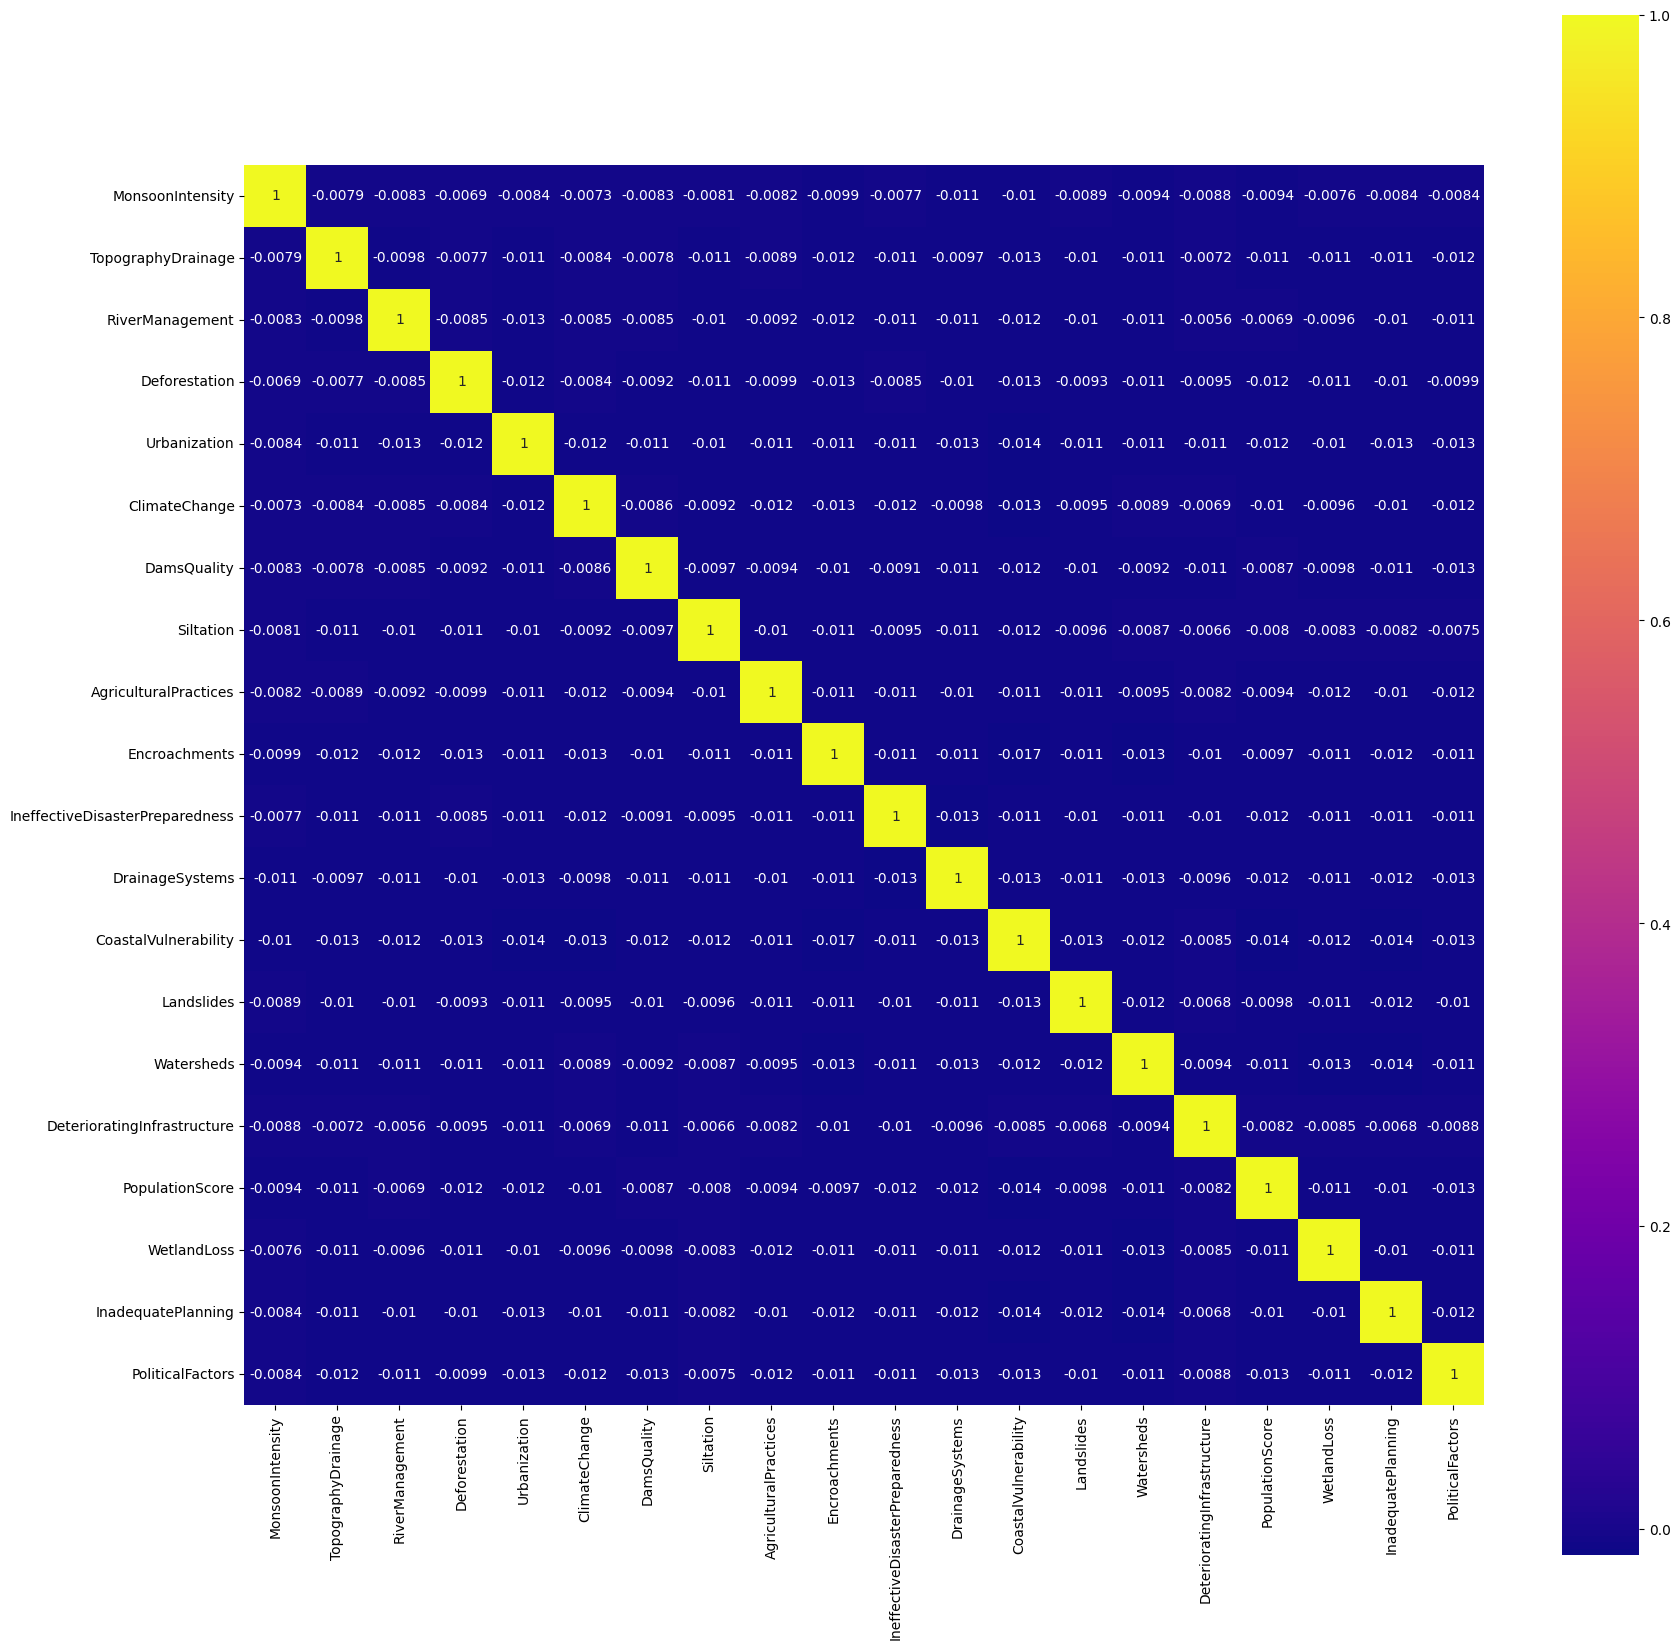

In [38]:
plt.figure(figsize=(20, 20))
sns.heatmap(X_train.corr(), vmax=1, square=True, annot=True, cmap="plasma")

### Feature Analyses


-----------------------------------
PCA Loadings 
-----------------------------------

                                      PC1       PC2       PC3       PC4  \
MonsoonIntensity                -0.025888  0.032611  0.074741  0.229240   
TopographyDrainage              -0.153216 -0.316583 -0.010796  0.146756   
RiverManagement                 -0.036124 -0.217104 -0.272081 -0.190873   
Deforestation                   -0.245432 -0.186298 -0.035272  0.491193   
Urbanization                     0.147719  0.093386  0.436995 -0.008096   
ClimateChange                   -0.064858 -0.388133 -0.209074  0.190560   
DamsQuality                     -0.026308 -0.336861  0.259597 -0.017161   
Siltation                        0.177626  0.187077 -0.045560 -0.052850   
AgriculturalPractices           -0.101869 -0.045596  0.132735 -0.314576   
Encroachments                    0.468671  0.073078  0.265789 -0.006731   
IneffectiveDisasterPreparedness -0.129367  0.220859  0.222790  0.220573   
DrainageSyst

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



-----------------------------------
Mutual Information Scores 
-----------------------------------

DamsQuality                        0.021063
MonsoonIntensity                   0.020689
DeterioratingInfrastructure        0.020536
PopulationScore                    0.020383
Landslides                         0.020242
Encroachments                      0.019940
Watersheds                         0.019577
PoliticalFactors                   0.019123
CoastalVulnerability               0.019100
Deforestation                      0.019071
RiverManagement                    0.019050
TopographyDrainage                 0.019043
IneffectiveDisasterPreparedness    0.018993
Siltation                          0.018875
WetlandLoss                        0.018717
AgriculturalPractices              0.018680
ClimateChange                      0.018657
InadequatePlanning                 0.018414
Urbanization                       0.018045
DrainageSystems                    0.017716
Name: Mutual Info S

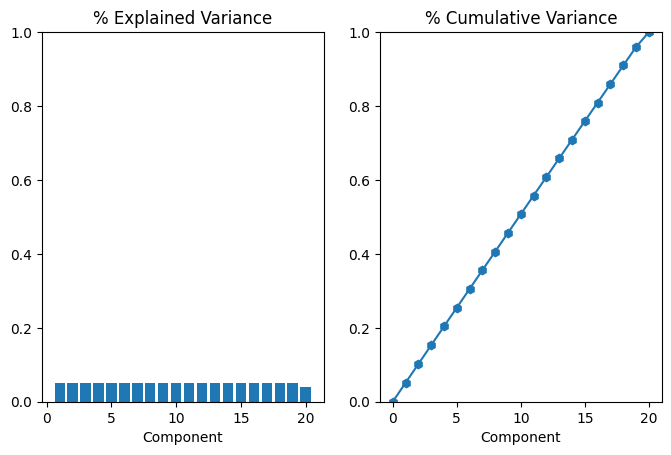

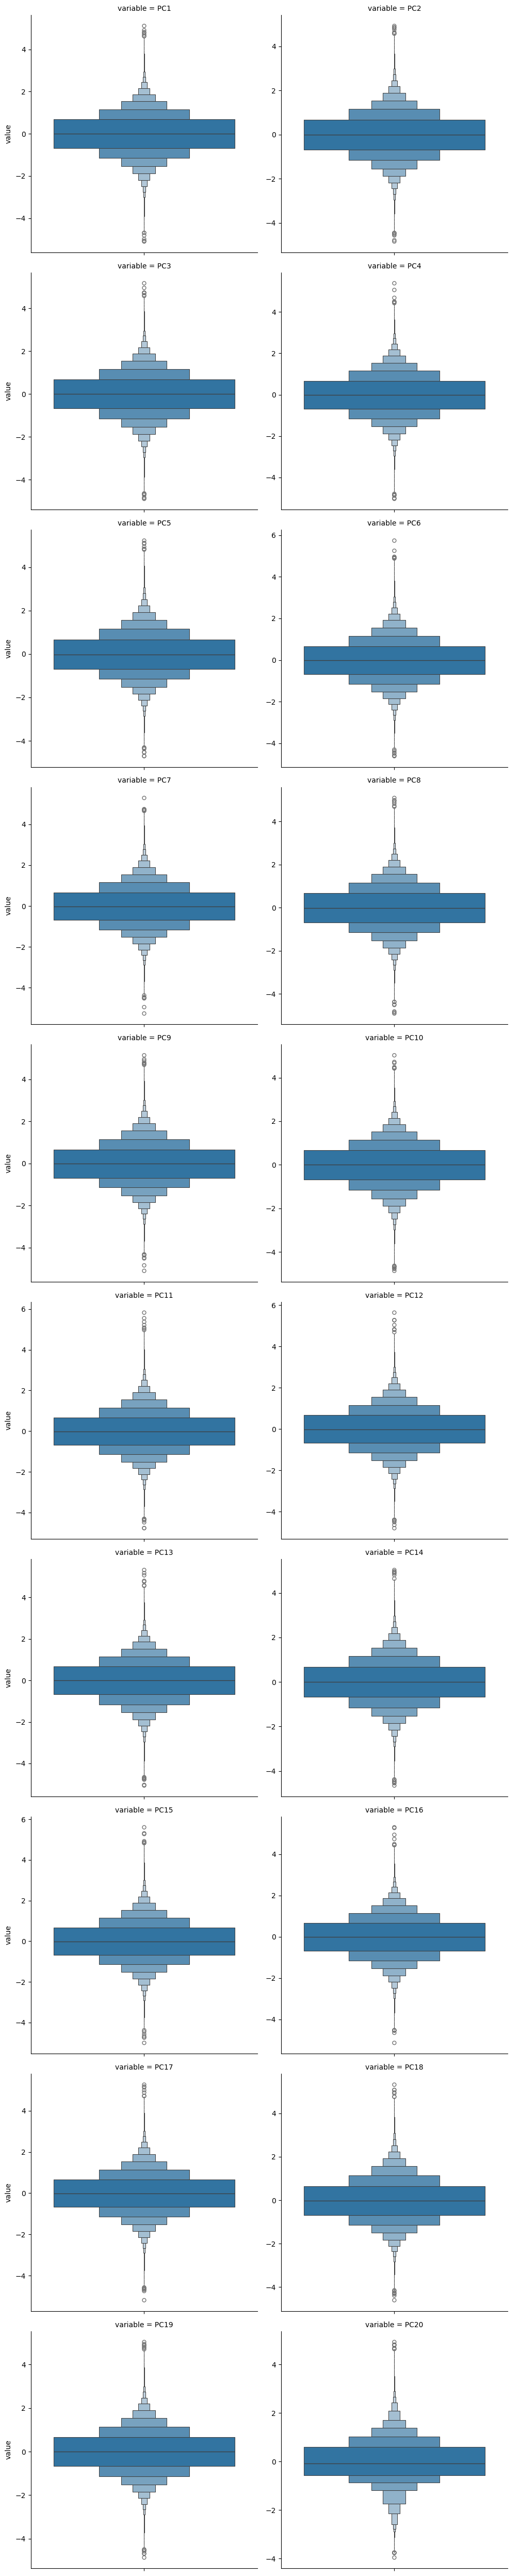

In [45]:
class FeatureAnalyzer:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.pca = PCA()
        self.pca.fit_transform(self.X)

    @property
    def X_pca(self):
        x_pca = self.pca.fit_transform(self.X)
        return pd.DataFrame(x_pca, columns=[f"PC{i+1}" for i in range(x_pca.shape[1])])

    @property
    def pca_loadings(self):
        return pd.DataFrame(self.pca.components_.T, columns=self.X_pca.columns, index=self.X.columns)

    def plot_variance(self, width=8, dpi=100):
        fig, axes = plt.subplots(1, 2)
        n = self.pca.n_components_
        print(f"\n{'-' * 35}\nPCA Loadings \n{'-' * 35}\n")
        print(self.pca_loadings)
        grid = np.arange(1, n+1)
        explained_variance = self.pca.explained_variance_ratio_
        axes[0].bar(grid, explained_variance)
        axes[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
        cumulative_variance = np.cumsum(explained_variance)
        axes[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], marker="h")
        axes[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))
        fig.set(figwidth=width, dpi=dpi)
        return axes

    def make_mi_scores(self, discrete_features: bool = False):
        mi_regression = mutual_info_regression(self.X, self.y, discrete_features=discrete_features)
        return pd.Series(mi_regression, name="Mutual Info Scores", index=self.X.columns).sort_values(ascending=False)

    def check_outliers(self):
        sns.catplot(
            y="value",
            col="variable",
            data=self.X_pca.melt(),
            kind="boxen",
            sharey=False,
            col_wrap=2
        )


def show_feature_analysis_artifacts(X, y):
    feature_analyzer = FeatureAnalyzer(X, y)
    feature_analyzer.plot_variance()
    mi_scores = feature_analyzer.make_mi_scores()
    feature_analyzer.check_outliers()
    print(f"\n{'-' * 35}\nMutual Information Scores \n{'-' * 35}\n")
    print(mi_scores)
    return feature_analyzer


feature_analyzer_object = show_feature_analysis_artifacts(X_train, y_train)

In [40]:
feature_analyzer_object.pca_loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MonsoonIntensity,-0.025888,0.032611,0.074741,0.229240,-0.037983,-0.136737,0.103842,0.195838,0.032802,-0.119222,-0.113378,0.083627,-0.276546,-0.313734,0.459822,0.090846,0.556623,0.226845,0.213561,0.184997
TopographyDrainage,-0.153216,-0.316583,-0.010796,0.146756,-0.079795,0.202366,-0.110058,0.208559,0.091901,-0.126337,0.619716,0.089337,0.361634,-0.097321,0.200637,-0.152739,0.089340,-0.170874,-0.217628,0.216577
RiverManagement,-0.036124,-0.217104,-0.272081,-0.190873,-0.025549,-0.211330,-0.008953,-0.093809,0.238274,-0.299849,-0.343164,0.192798,0.222114,-0.091630,-0.266041,0.329036,0.253407,-0.069023,-0.367006,0.211767
Deforestation,-0.245432,-0.186298,-0.035272,0.491193,-0.046792,-0.141424,-0.275011,0.083165,0.091751,-0.078805,-0.338337,-0.074064,0.067134,0.182480,-0.159620,-0.426727,-0.174546,0.314646,0.048838,0.214438
Urbanization,0.147719,0.093386,0.436995,-0.008096,-0.043792,0.187062,0.261163,0.427541,0.371075,0.242797,-0.158905,-0.078205,0.218075,-0.228939,-0.277730,0.086864,-0.116868,0.009819,0.066890,0.244191
ClimateChange,-0.064858,-0.388133,-0.209074,0.190560,0.295983,0.057621,0.350851,-0.053989,-0.163459,0.273331,-0.101602,0.231238,-0.205433,-0.214460,0.165479,0.158385,-0.432244,-0.054468,-0.083456,0.213378
DamsQuality,-0.026308,-0.336861,0.259597,-0.017161,-0.157797,-0.208339,0.111501,-0.258581,-0.165119,-0.211167,0.356003,-0.263858,-0.215693,-0.119005,-0.410572,0.192694,-0.026037,0.172135,0.247354,0.210837
Siltation,0.177626,0.187077,-0.045560,-0.052850,0.266364,-0.028409,0.104566,0.060735,-0.209503,0.020692,0.133343,-0.308252,0.186440,0.164595,0.124980,0.141307,-0.008853,0.606959,-0.421171,0.204406
AgriculturalPractices,-0.101869,-0.045596,0.132735,-0.314576,-0.184134,0.042510,-0.369545,0.401504,-0.006063,-0.175629,-0.036054,0.090455,-0.375309,0.272027,0.199406,0.294828,-0.323038,0.005500,-0.055006,0.219477
Encroachments,0.468671,0.073078,0.265789,-0.006731,-0.096501,0.086385,-0.220863,-0.317405,-0.058029,0.076312,0.045641,0.566215,-0.129986,-0.071916,-0.074784,-0.244694,0.018540,0.152178,-0.183224,0.248062


#### Visualize principal components

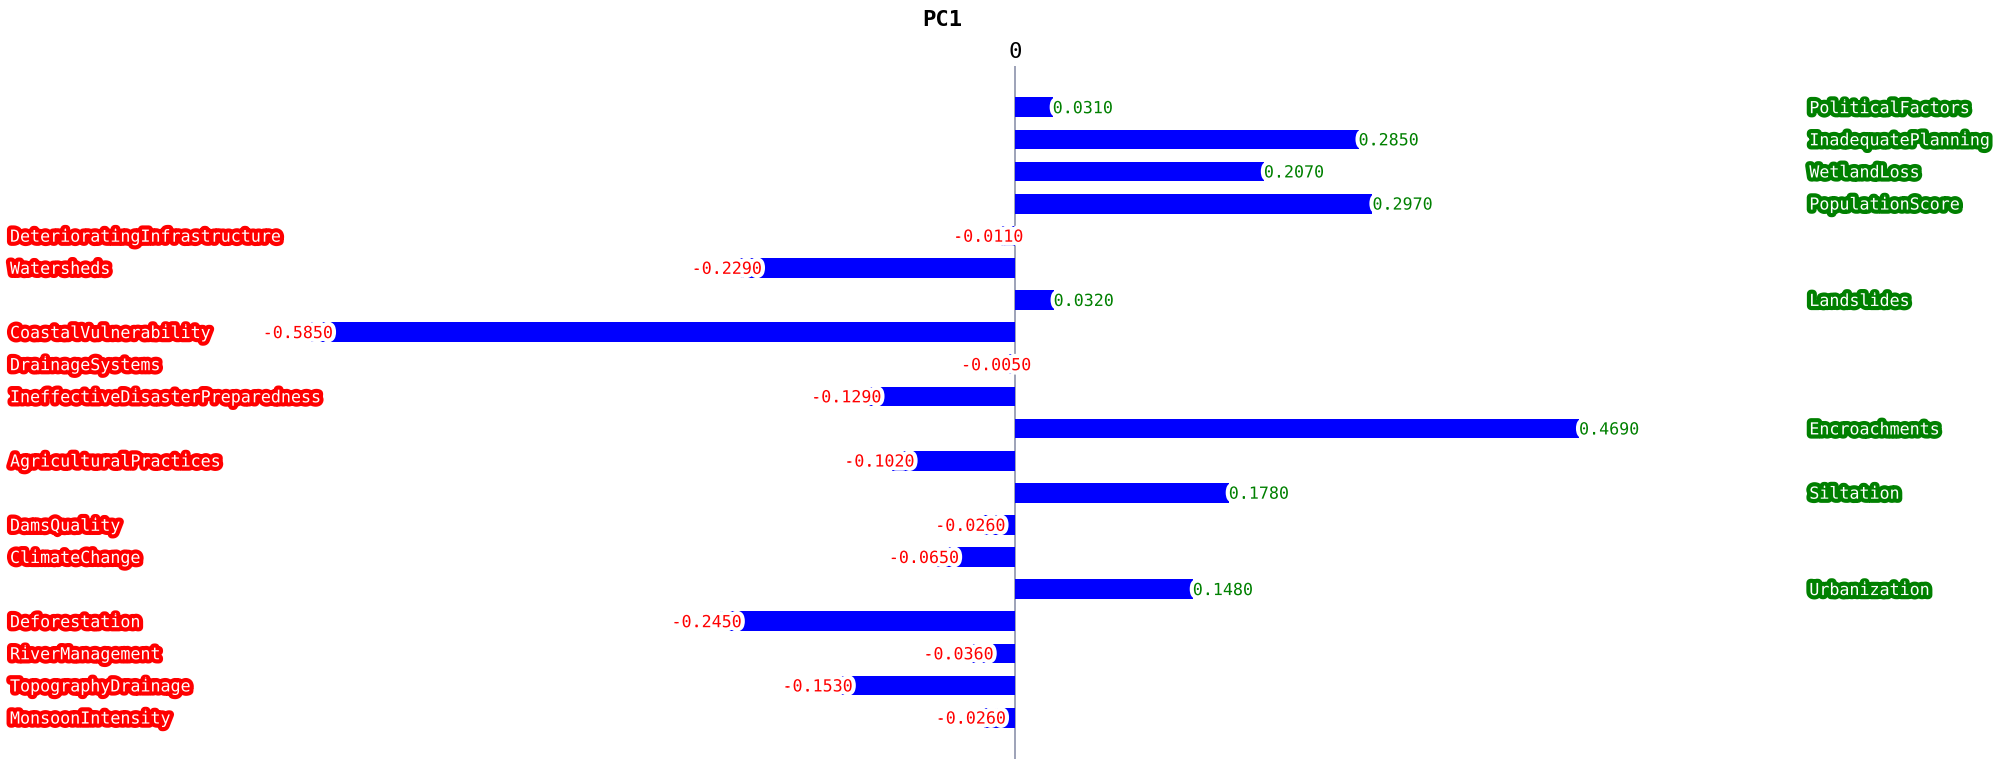

In [49]:
def plot_principal_component(feature_analyzer_object, level=1):
    if level < 1:
        raise ValueError("PC level can't be less than 1")
    _loadings = feature_analyzer_object.pca_loadings
    _column = _loadings.columns[level - 1]
    pc_dataframe = _loadings.loc[:, _column].reset_index().to_dict(orient="records")
    feature_to_pc1 = {_entry["index"]: float(_entry[_column]) for _entry in pc_dataframe}
    chart = Charts(data=feature_to_pc1, font_family="monospace")
    chart.plot(title=_column)

plot_principal_component(feature_analyzer_object, level=1)

#### Adding new features [test]

In [42]:
X_train_new = X_train.copy(deep=True)
X_train_new["IsCoastalVulnerability"] = X_train["CoastalVulnerability"] > 0
X_train_new["IsIneffectiveDisasterPreparedness"] = X_train["IneffectiveDisasterPreparedness"] > 0
X_train_new["IsDeforestation"] = X_train["Deforestation"] > 0
X_test_new = X_test.copy(deep=True)
X_test_new["IsCoastalVulnerability"] = X_test["CoastalVulnerability"] > 0
X_test_new["IsIneffectiveDisasterPreparedness"] = X_test["IneffectiveDisasterPreparedness"] > 0
X_test_new["IsDeforestation"] = X_test["Deforestation"] > 0

## **Training the model**

In [52]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor


class RegressionModel:
    def __init__(
        self,
        train_data: tuple,
        test_data: tuple,
        learning_rate=0.01,
        n_estimators=1000,
        early_stopping_rounds=5,
        corss_validation_folds=10,
        n_jobs=1
    ):
        self.model = XGBRegressor()
        self.train_data = train_data
        self.test_data = test_data
        self.learning_curve_params = {
            "X": train_data[0],
            "y": train_data[1],
            "train_sizes": np.linspace(0.1, 1, 10),
            "cv": corss_validation_folds,
            "n_jobs": n_jobs
        }

    @property
    def pipeline(self):
        return make_pipeline(self.model)

    def plot_learning_curve(self):
        def plot(data_sizes, scores, plot_params):
            data_average = np.mean(scores, axis=1)
            data_std = np.std(scores, axis=1)
            plt.plot(
                data_sizes,
                data_average,
                **plot_params
            )
            plt.fill_between(
                data_sizes,
                data_average + data_std,
                data_average - data_std,
                alpha=0.15,
                color=plot_params["color"]
            )

        train_sizes, train_scores, test_scores = learning_curve(
            estimator=self.pipeline,
            **self.learning_curve_params
        )
        plot(train_sizes, train_scores, dict(color="blue", marker="o", markersize=5, label="Training accuracy"))
        plot(train_sizes, test_scores, dict(color="red", marker="s", linestyle="--", markersize=5, label="Validation accuracy"))
        plt.grid()
        plt.xlabel("Number of training examples")
        plt.ylabel("Accuracy")
        plt.legend(loc="lower right")
        # plt.ylim([0.8, 1.03])
        plt.show()

In [51]:
models = list()

In [ ]:
model = RegressionModel(train_data=(X_train, y_train), test_data=(X_test, y_test))
model.plot_learning_curve()
models.append(model)